# Krypton waveform NB

- Chamber at 10 bar

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-16 08:56:34


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from typing      import NamedTuple

## NB functions

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [10]:
def plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min, t_max):

    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)


In [11]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [12]:
def display_s12s(s12s):
    for s12 in s12s:
        print('energy = {} pes charge = {} pes time = {} mus width = {} ns'.format(
        s12.total_energy, s12.total_charge, s12.time_at_max_energy/units.mus, s12.width))

In [13]:
def plot_sipm_signals_vs_time_mus(sipm_signals,
                                  sipm_min      =    0,
                                  sipm_max      = 2000,
                                 figsize=(6,6)):
    """Plot PMT signals versus time in mus  and return figure."""


    plt.figure(figsize=figsize)   
    plt.ylabel(r'q (pes/adc)')
    plt.xlabel(r'sipm number ')
    ax = plt.subplot()
    ax.set_xlim([sipm_min, min(sipm_max, len(sipm_signals))])
    plt.grid(True)
    plt.plot(sipm_signals)
       


In [14]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [15]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [16]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [17]:
class KrDst(NamedTuple):
    es1  : float
    ws1  : float
    es2  : float
    ws2  : float
    qs2  : float
    dt   : float 
    c    : Cluster


In [18]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [19]:
KR = []

## Data base

In [19]:
run_number = 5406
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [20]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [21]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,21.33,0.77,11.33
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,23.37,0.00,11.54
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,26.02,0.81,10.62
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,25.74,0.00,11.86
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,30.00,0.75,13.15
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,22.66,0.75,9.88
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,25.09,0.00,11.04
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,32.66,0.00,14.72
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,23.10,0.00,10.60
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,25.47,0.00,10.37


In [22]:
channel_id

array([ 0, 12,  1, 13, 19, 18,  7,  6,  2, 16,  5,  4])

In [23]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

In [24]:
sipm_adc_to_pes[181] = 0

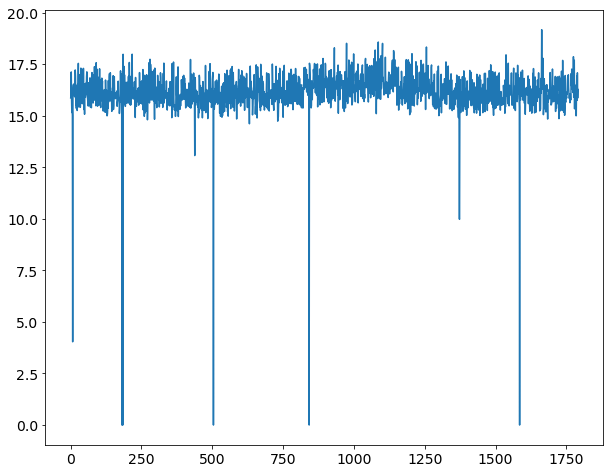

In [25]:
plt.plot(sipm_adc_to_pes)

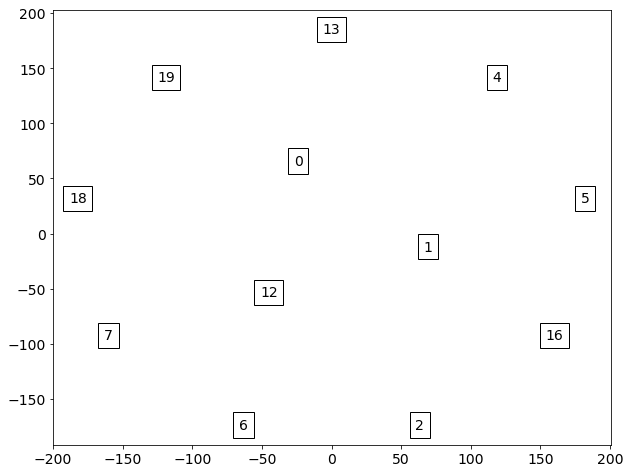

In [26]:
mpl.draw_pmt_map(run_number)

In [27]:
adc_to_pes

array([ 21.33,  23.37,  26.02,  25.74,  30.  ,  22.66,  25.09,  32.66,
        23.1 ,  25.47,  20.8 ,  21.99])

## Input file

In [28]:
filename = f'/Users/jjgomezcadenas/Projects/ICDEV/data/{run_number}/run_{run_number}_0000_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [29]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [30]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [31]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [32]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [33]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event

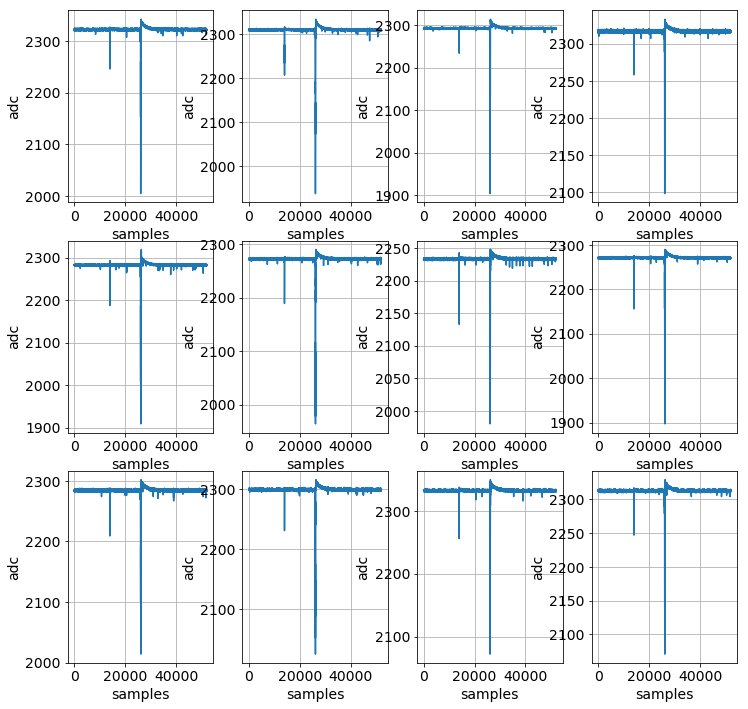

In [34]:
event=0
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

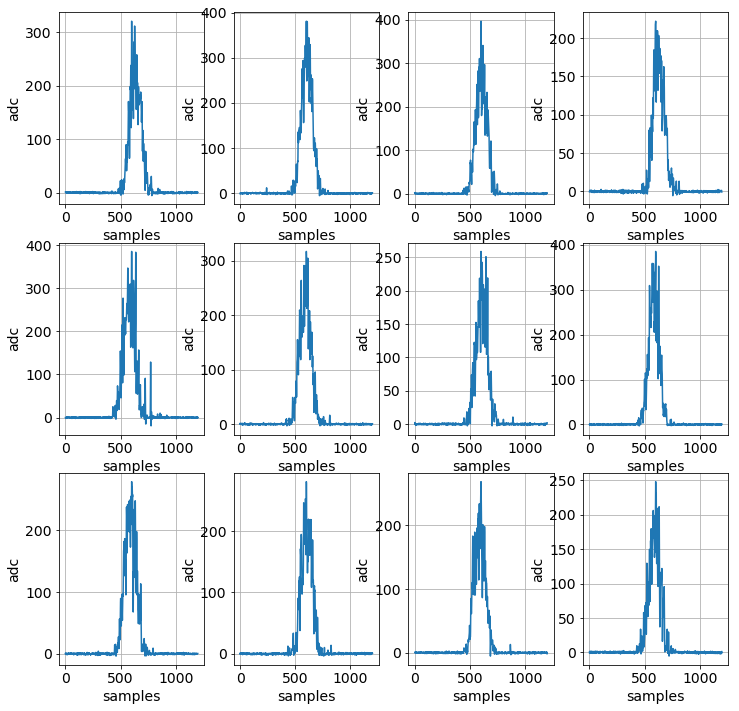

In [35]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

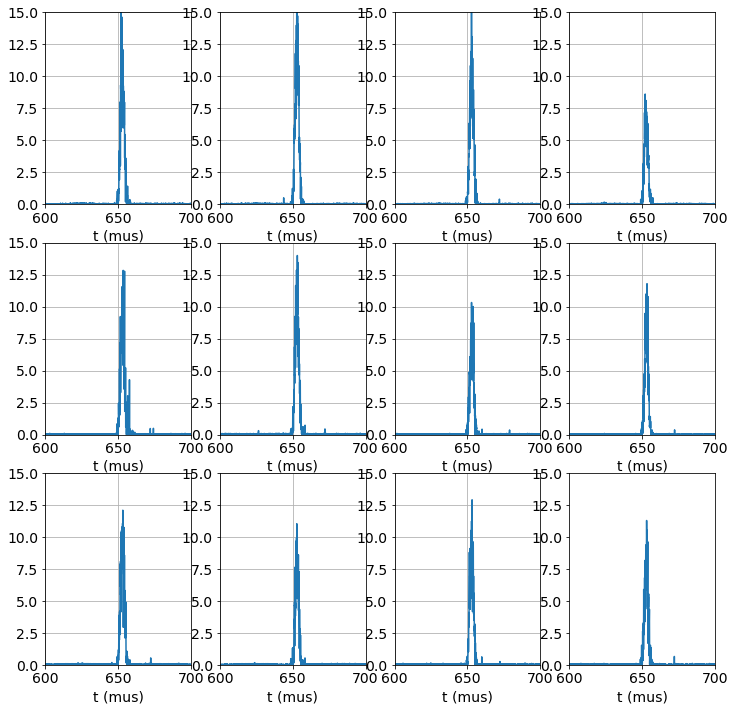

In [38]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

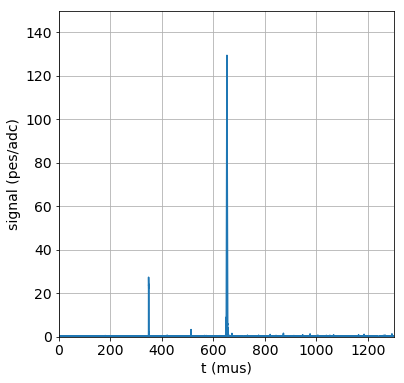

In [42]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

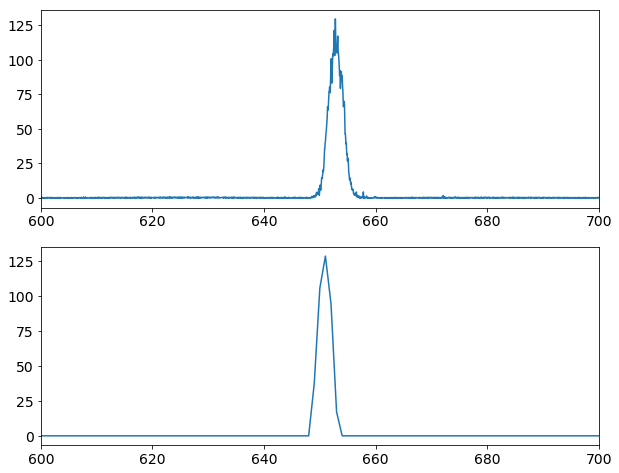

In [44]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

In [45]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 350.45   350.475  350.5    350.525] µs
 Time @ max energy: 350.475
 Width: 0.075 µs
 Height: 1.978755304540938 pes
 Energy: 6.18657292132696 pes
 Charge: 0.0 pes
 RMS: 0.0257234873710918 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 350.875  350.9    350.925  350.95 ] µs
 Time @ max energy: 350.9
 Width: 0.075 µs
 Height: 1.6939630493918365 pes
 Energy: 5.271953869022697 pes
 Charge: 0.0 pes
 RMS: 0.02501022405694604 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 513.275  513.3    513.325  513.35   513.375  513.4    513.425] µs
 Time @ max energy: 513.35
 Width: 0.15 µs
 Height: 3.338181916208642 pes
 Energy: 15.432783019014664 pes
 Charge: 0.0 pes
 RMS: 0.040383342259184475 µs]

In [46]:
s2params = S12Params(time = minmax(min    = 600 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 40, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.83007193  649.61151595  650.63966639  651.54619856  652.51003783
 653.45938538  654.39105843  655.33946448  656.36085026  657.64150647
 658.27365675] µs
       Time @ max energy: 652.5100378280185
       Width: 9.443584821677534 µs
       Height: 4224.129687636173 pes
       Energy: 14416.178452552838 pes
       Charge: 383.65803025385316 pes
       RMS: 1.2199471428239004 µs]

[[717]
 [718]
 [725]
 [726]
 [727]
 [733]
 [734]]


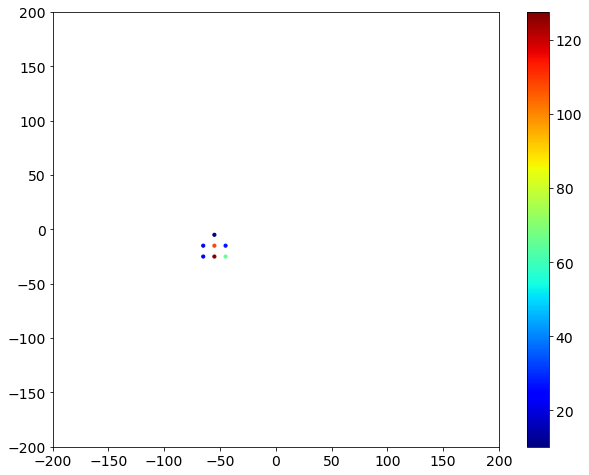

In [47]:
plot_sipm_map(sipm_cal)

### Event

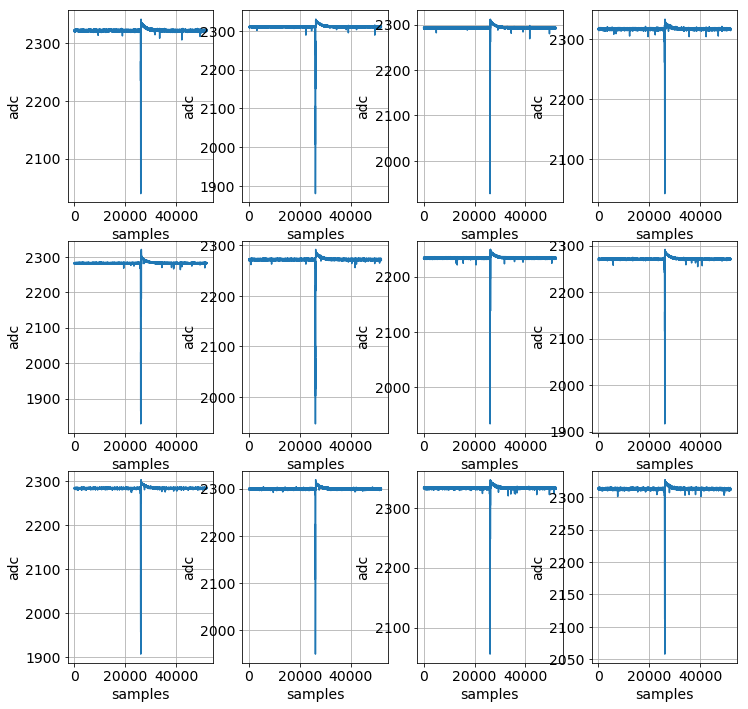

In [48]:
event=1
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

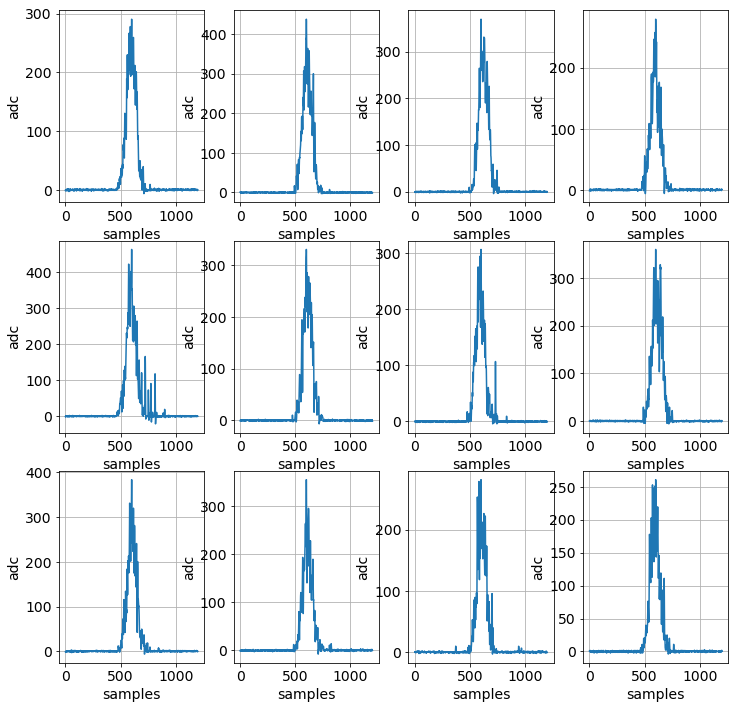

In [49]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

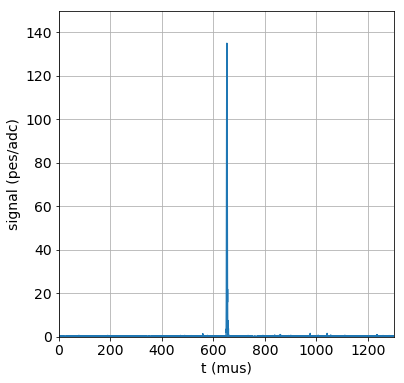

In [51]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

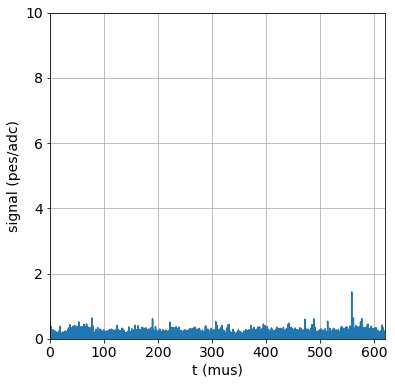

In [52]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [53]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 558.75   558.775  558.8    558.825  558.85   558.875] µs
 Time @ max energy: 558.825
 Width: 0.125 µs
 Height: 1.4352364110606026 pes
 Energy: 6.374378375646747 pes
 Charge: 0.0 pes
 RMS: 0.03759598407105302 µs]

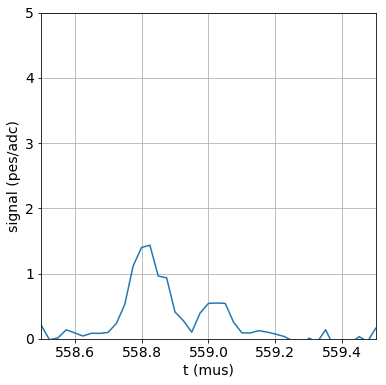

In [55]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =558.5,
                            t_max      = 559.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [56]:
s2params = S12Params(time = minmax(min    = 620 * units.mus,
                                   max    = 720 * units.mus),
                           stride = 40,
                           length = minmax(min = 4, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.80837362  650.6592211   651.58289421  652.50362207  653.44694986
 654.34525821  655.3436667   656.26089822  657.29198931  658.18229406] µs
       Time @ max energy: 652.5036220681558
       Width: 8.373920435006847 µs
       Height: 4849.174571806149 pes
       Energy: 13363.622649217827 pes
       Charge: 363.0952053165534 pes
       RMS: 1.0600087934962719 µs]

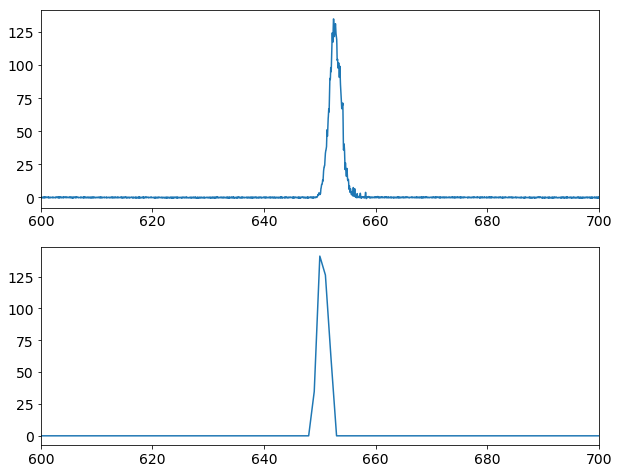

In [57]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[971]
 [978]
 [979]
 [980]
 [987]]


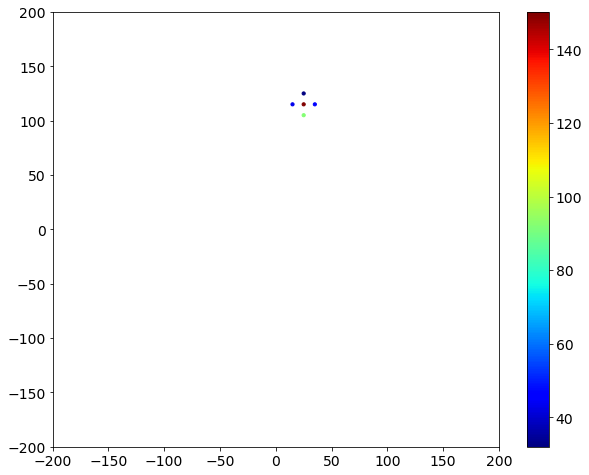

In [58]:
plot_sipm_map(sipm_cal)

### Event

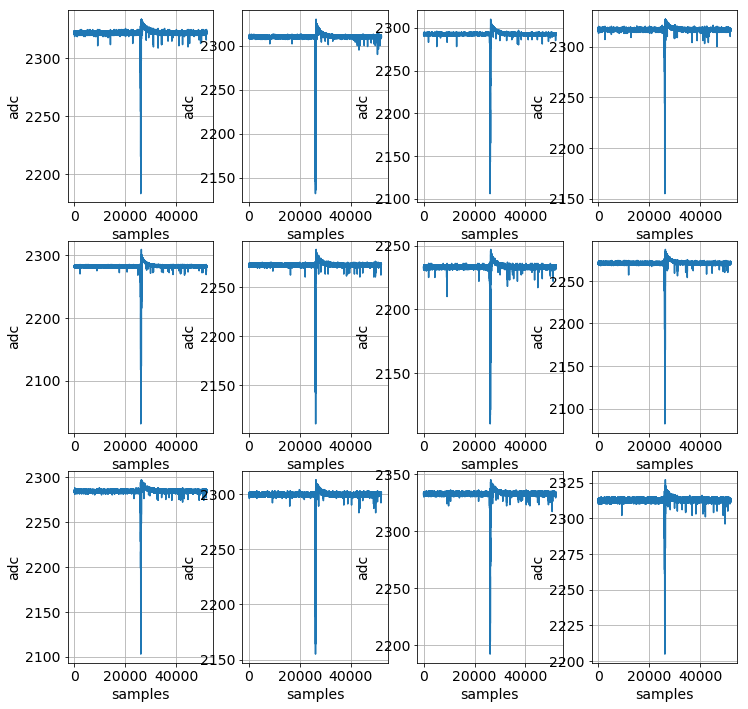

In [59]:
event=2
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

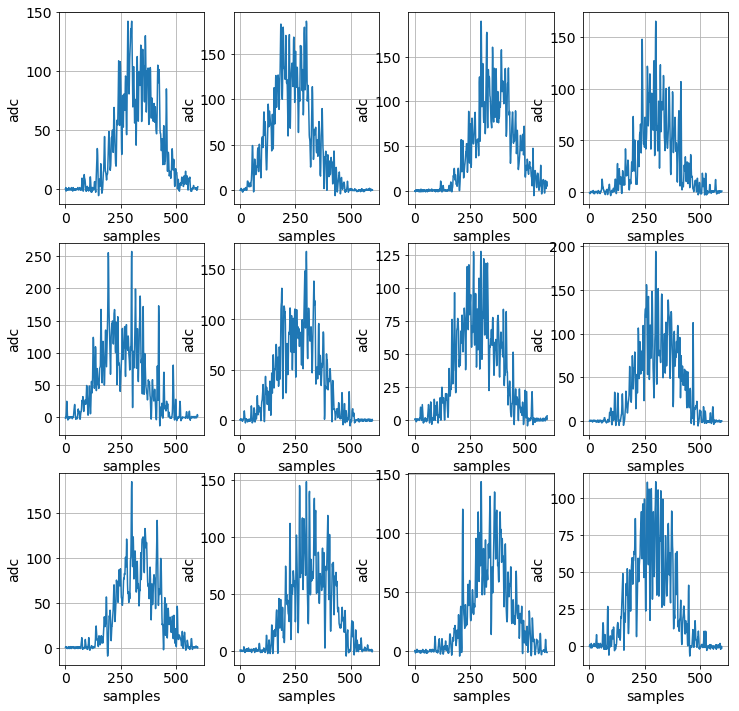

In [60]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=300, figsize=(12,12))

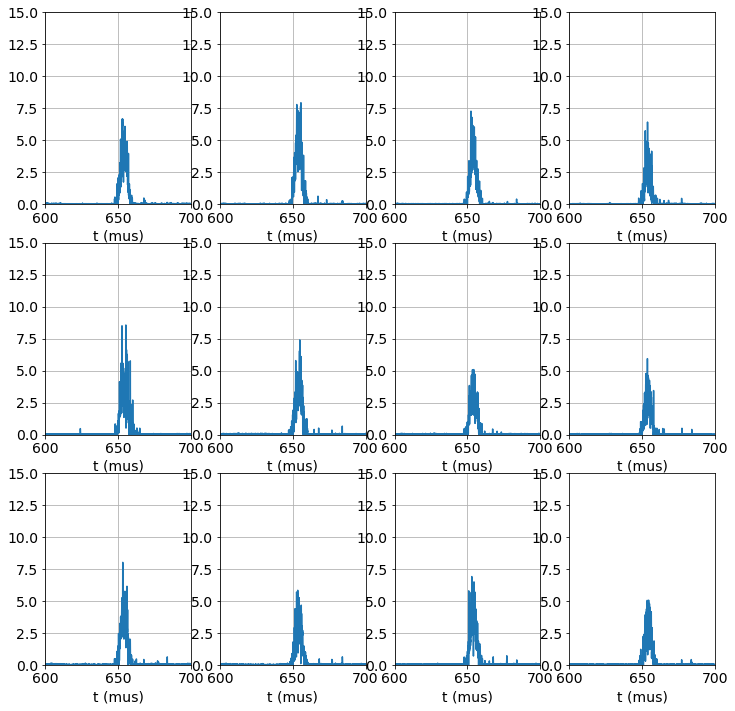

In [61]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

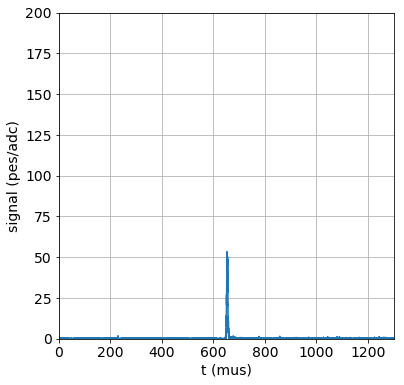

In [62]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

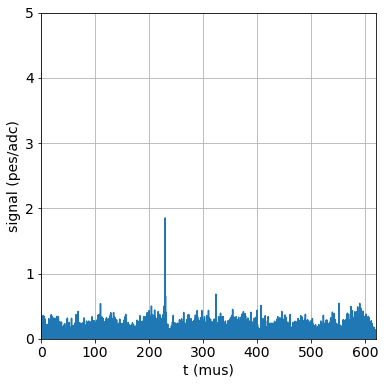

In [63]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

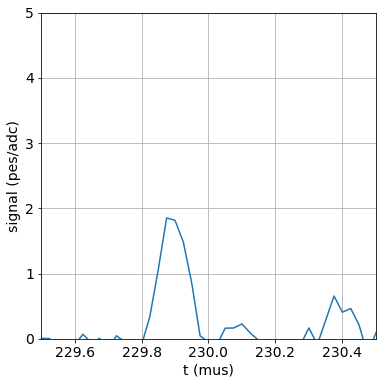

In [70]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =229.5,
                            t_max      = 230.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [68]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 229.85   229.875  229.9    229.925  229.95 ] µs
 Time @ max energy: 229.875
 Width: 0.1 µs
 Height: 1.852627159366116 pes
 Energy: 7.06437298795037 pes
 Charge: 0.0 pes
 RMS: 0.031059716511542476 µs]

In [71]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 647.79533383  648.63451436  649.56372192  650.56168744  651.52630898
 652.52637712  653.47023121  654.49915374  655.45951023  656.43171413
 657.41882391  658.44521398  659.36893673  660.11569673] µs
       Time @ max energy: 653.4702312146327
       Width: 12.320362897514482 µs
       Height: 1794.5423370248736 pes
       Energy: 10585.362193636756 pes
       Charge: 97.74710909522082 pes
       RMS: 2.1134828332708095 µs]

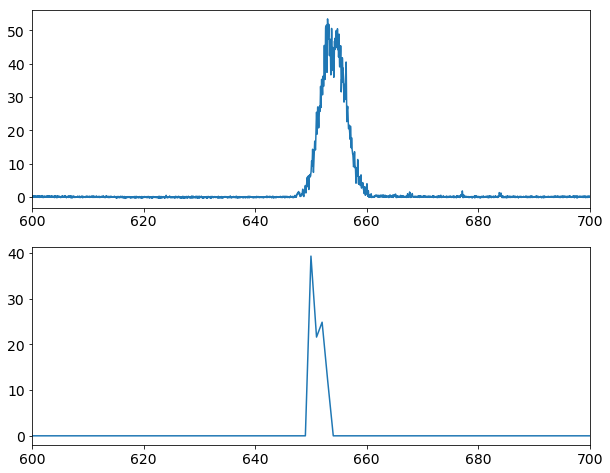

In [72]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[1213]
 [1214]
 [1473]
 [1474]]


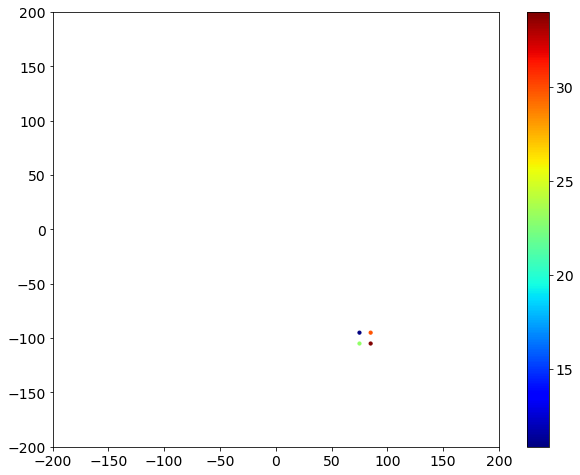

In [73]:
plot_sipm_map(sipm_cal)

### Event

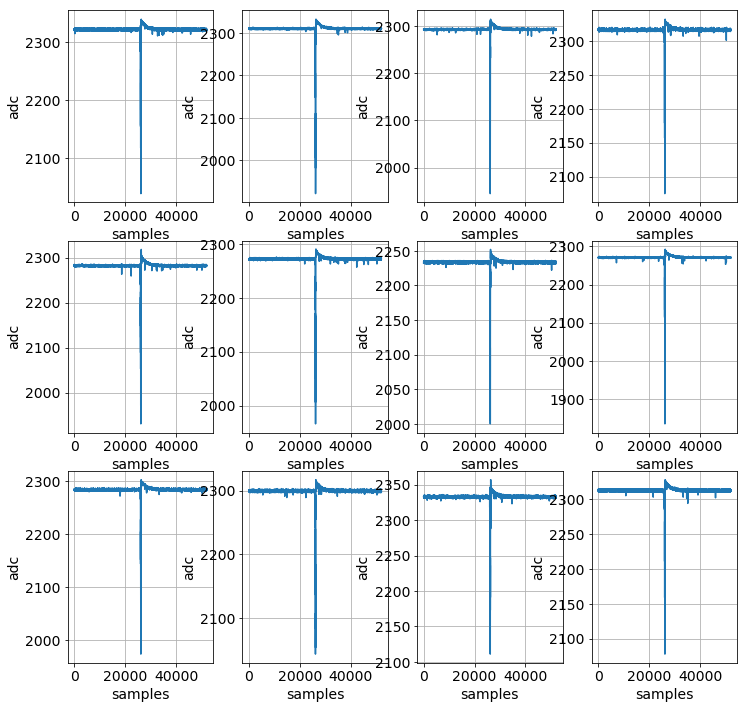

In [74]:
event=3
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

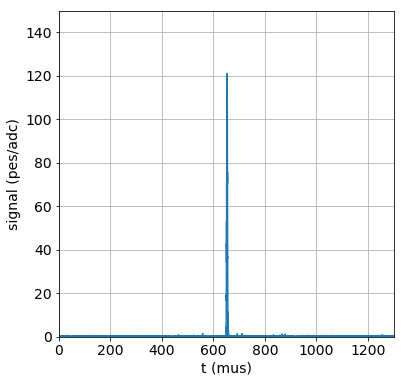

In [76]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

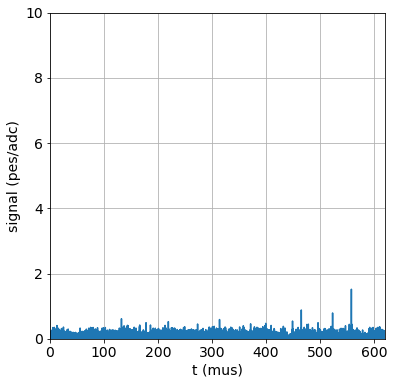

In [77]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

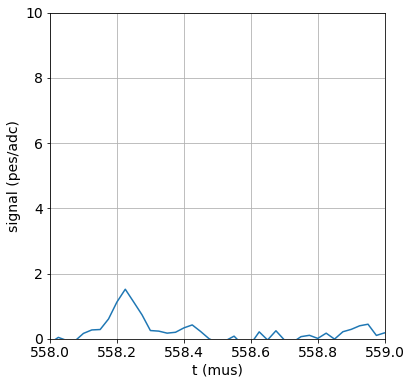

In [79]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =558,
                            t_max      = 559,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [78]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 558.175  558.2    558.225  558.25   558.275] µs
 Time @ max energy: 558.225
 Width: 0.1 µs
 Height: 1.5193666801180008 pes
 Energy: 5.118550094385105 pes
 Charge: 0.0 pes
 RMS: 0.03049206866504335 µs]

In [80]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 740 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.88964643  649.62016321  650.60670915  651.52980993  652.53939233
 653.51017767  654.43719514  655.38228865  656.35008996  657.48069269
 658.25138775] µs
       Time @ max energy: 653.5101776672859
       Width: 9.361741318236222 µs
       Height: 4066.59362544155 pes
       Energy: 15677.959177933828 pes
       Charge: 386.5719781431699 pes
       RMS: 1.4586853477656971 µs]

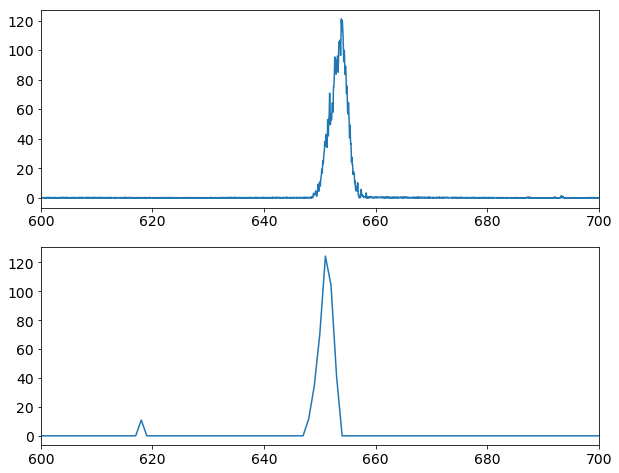

In [81]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[  7]
 [716]
 [717]
 [718]
 [724]
 [725]
 [726]]


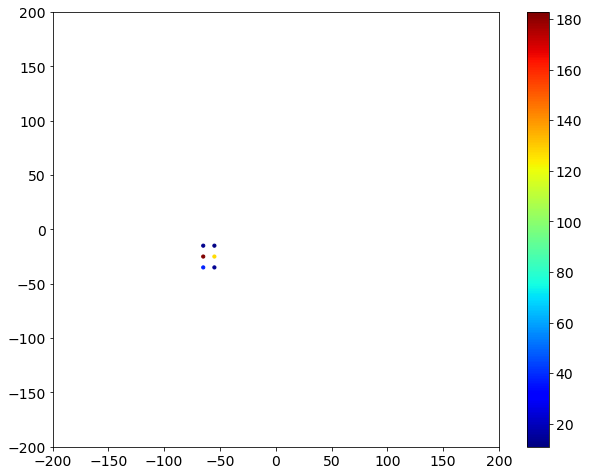

In [82]:
plot_sipm_map(sipm_cal)